In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from os import path

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from IPython.display import SVG
import re

In [58]:
df = pd.read_csv('data/curated.csv', index_col=0)
df.head(3)

,id,mol_weight,formula,O,Br,As,C,H,R,F,...,Mo,Zn,S,Se,P,Cl,N,X,Mg,polymer
0,C00002,507.1810,C10H16N5O13P3,13,0,0,10,16,0,0,...,0,0,0,0,3,0,5,0,0,0
1,C00003,664.4330,C21H28N7O14P2,14,0,0,21,28,0,0,...,0,0,0,0,2,0,7,0,0,0
2,C00005,745.4209,C21H30N7O17P3,17,0,0,21,30,0,0,...,0,0,0,0,3,0,7,0,0,0


In [59]:
pairs = pd.read_csv('data/Main_RPAIRS_KEGG_fixed.csv')
pairs.head(3)

,Reactant_pair,CAR,KEGG_reactions,RPAIR_main,source,target
0,C00002_C07024,1.0,R05668,True,C00002,C07024
1,C00003_C00004,1.0,"R00091,R00094,R00143,R00145,R00203,R00209,R002...",True,C00003,C00004
2,C00005_C00006,1.0,"R00114,R00134,R00146,R00205,R00216,R00243,R002...",True,C00005,C00006


In [60]:
# Fill NaN mw with 500
df['mol_weight'].fillna(500, inplace=True)

In [61]:
if path.exists('data/nodes_centralities.csv'):
    dc = pd.read_csv('data/nodes_centralities.csv', index_col=0)
else:
    print('No centralities file...')
    
dc.rename({'Node':'id'}, axis=1, inplace=True)
dc.head()

,id,Degree Centrality,PageRank,Betweenness Centrality,formula,mol_weight
0,C00001,0.163018,0.034408,0.473722,H2O,18.0153
1,C00007,0.127247,0.030908,0.284550,O2,31.9988
2,C00019,0.064068,0.016209,0.134686,C15H22N6O5S,398.4374
3,C00029,0.033814,0.007744,0.061145,C15H24N2O17P2,566.3018
4,C00002,0.040043,0.007642,0.070029,C10H16N5O13P3,507.1810


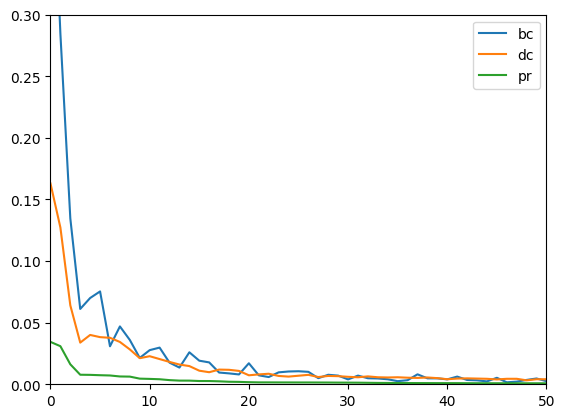

In [62]:
plt.plot(dc.index, dc['Betweenness Centrality'])
plt.plot(dc.index, dc['Degree Centrality'])
plt.plot(dc.index, dc['PageRank'])
plt.legend(['bc','dc','pr'])
plt.xlim(0, 50)
plt.ylim(0, 0.3)
plt.show()

In [63]:
df = pd.merge(df, dc, on='id')

# Drop columns with '_y' in their name
cols_to_keep = df.filter(regex='^(?!.*_y)').columns
df = df[cols_to_keep]
df = df.rename(columns=lambda x: x.replace('_x',''))
df.head()

,id,mol_weight,formula,O,Br,As,C,H,R,F,...,Se,P,Cl,N,X,Mg,polymer,Degree Centrality,PageRank,Betweenness Centrality
0,C00002,507.1810,C10H16N5O13P3,13,0,0,10,16,0,0,...,0,3,0,5,0,0,0,0.040043,0.007642,0.070029
1,C00003,664.4330,C21H28N7O14P2,14,0,0,21,28,0,0,...,0,2,0,7,0,0,0,0.001780,0.000315,0.000102
2,C00005,745.4209,C21H30N7O17P3,17,0,0,21,30,0,0,...,0,3,0,7,0,0,0,0.000534,0.000118,0.000018
3,C00007,31.9988,O2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.127247,0.030908,0.284550
4,C00011,44.0095,CO2,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.038263,0.007359,0.075367


# Import to Networkx 

In [65]:
import networkx as nx

G = nx.Graph()

# add edges from the DataFrame
G.add_edges_from(pairs[['source', 'target']].values)

# Add df cols as node features
node_data = df.set_index('id').to_dict('index')

# Add the node features to the graph
for node, data in G.nodes(data=True):
    node_features = node_data.get(node)
    if node_features:
        data.update(node_features)

print(G.number_of_nodes(), G.number_of_edges())

5620 10747


#### Add edge attributes

In [67]:
def get_weights(a,b):
    if b in dc['id'][:20].values or a in dc['id'][:20].values:
        return 999
    else:
        return 0
    
# for edge in G.edges():
#     G.edges[(edge[0], edge[1])]['weight'] = get_weights(G.nodes[edge[0]]['mol_weight'], 
#                                                         G.nodes[edge[1]]['mol_weight'])
    
for edge in G.edges():
    G.edges[(edge[0], edge[1])]['weight'] = get_weights(edge[0], edge[1])

ex. Coa is C00010

In [68]:
source = 'C00082'
target = 'C01533'
list(nx.shortest_path(G, source, target, weight='weight'))

['C00082',
 'C00811',
 'C01197',
 'C01494',
 'C05619',
 'C00482',
 'C05610',
 'C02325',
 'C01533']

### Get node embeddings using GNN and Clustering (idea)

In [69]:
from torch_geometric.utils.convert import from_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

node_features = [col for col in df.drop(['id', 'formula', 'mol_weight'], axis=1).columns]

data = from_networkx(G, group_node_attrs=node_features)
data.y = data.mol_weight

data.y = data.y.to(torch.float32)
data.x = data.x.to(torch.float32)

data.x.shape, data.y.shape

(torch.Size([5620, 22]), torch.Size([5620]))

In [70]:
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)

# Add a new column to data.x with the node names from the mapping
node_names = [None] * len(data.x)
for node, index in mapping.items():
    node_names[index] = node
    
graph_data = np.column_stack((data.x, node_names))
graph_data = pd.DataFrame(graph_data)
graph_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,13.0,0.0,0.0,10.0,16.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,5.0,0.0,0.0,0.0,0.040042713,0.007642341,0.07002883,C00002
1,13.0,0.0,0.0,10.0,14.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,5.0,0.0,0.0,0.0,0.00053390284,0.0001222408,1.0827169e-05,C07024
2,14.0,0.0,0.0,21.0,28.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,7.0,0.0,0.0,0.0,0.0017796761,0.00031517228,0.00010244438,C00003


In [71]:
# Split nodes into train/val/test
split = T.RandomNodeSplit(num_val=.1, num_test=.2)
data = split(data)
data

Data(edge_index=[2, 21487], mol_weight=[5620], formula=[5620], weight=[21487], x=[5620, 22], y=[5620], train_mask=[5620], val_mask=[5620], test_mask=[5620])

In [84]:
from torch_geometric.nn import GATConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.x.shape[1], 400)
        self.conv2 = GCNConv(400, 800)
        self.conv3 = GCNConv(800, 200)
        self.linear = nn.Linear(200, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=.6, training=self.training)
        x = self.linear(x)

        return x

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(22, 400)
  (conv2): GCNConv(400, 800)
  (conv3): GCNConv(800, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)


In [85]:
# Train model
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out
    mae = mean_absolute_error(pred[data.test_mask], data.y[test_mask])
    return mae

for epoch in range(1, 10000):
    if epoch % 250 == 0:
        loss = train()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3934])) that is different to the input size (torch.Size([3934, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 250, Loss: 212988.6875
Epoch: 500, Loss: 179922.5938
Epoch: 750, Loss: 124382.5234
Epoch: 1000, Loss: 336923.3125
Epoch: 1250, Loss: 131561.5469
Epoch: 1500, Loss: 136429.3281
Epoch: 1750, Loss: 165633.1719
Epoch: 2000, Loss: 182838.3906
Epoch: 2250, Loss: 191215.0781
Epoch: 2500, Loss: 193502.0156
Epoch: 2750, Loss: 192977.6250
Epoch: 3000, Loss: 188837.2031
Epoch: 3250, Loss: 181753.6562
Epoch: 3500, Loss: 170273.0312
Epoch: 3750, Loss: 154012.2188
Epoch: 4000, Loss: 134212.6406
Epoch: 4250, Loss: 118532.7500
Epoch: 4500, Loss: 130106.3047
Epoch: 4750, Loss: 140823.5312
Epoch: 5000, Loss: 133999.5156
Epoch: 5250, Loss: 124712.4766
Epoch: 5500, Loss: 122118.6328
Epoch: 5750, Loss: 125008.4141
Epoch: 6000, Loss: 130447.9609
Epoch: 6250, Loss: 132750.1562
Epoch: 6500, Loss: 128960.0703
Epoch: 6750, Loss: 124219.1250
Epoch: 7000, Loss: 117686.9766
Epoch: 7250, Loss: 120797.7500
Epoch: 7500, Loss: 124644.0781
Epoch: 7750, Loss: 124918.7500
Epoch: 8000, Loss: 118003.9219
Epoch: 8250

In [86]:
model.eval()
out = model(data.x, data.edge_index)
pred = model(data.x, data.edge_index)
y_pred = pred.detach().numpy().reshape(-1,)
err = mean_absolute_error(y_pred, data.y.detach().numpy())
print(err)

145.89279


In [92]:
results = pd.DataFrame()
results['true'] = data.y.numpy()
results['pred'] = y_pred

In [93]:
results

,true,pred
0,507.181000,1833.155884
1,505.165100,232.287552
2,664.432983,364.261169
3,665.440979,313.314575
4,745.420898,290.981567
...,...,...
5615,20.006300,252.658997
5616,28.010099,206.576218
5617,500.000000,687.983154
5618,34.080898,118.749664
